# 빅쿼리 연결

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# seaborn이 폰트 바꾸지 못하게 아래 한 줄 추가
plt.rcParams["font.family"] = "NanumGothic"

# 폰트 경고 방지
plt.rcParams["axes.unicode_minus"] = False


In [ ]:
# # Colab에서 plotly 시각화 가능하게 설정
# init_notebook_mode(connected=True)
# pio.renderers.default = 'colab'  # 또는 'iframe_connected', 'notebook'

In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'

In [ ]:
# BigQuery
from google.cloud import bigquery

# viz libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
# import squarify
import plotly.express as px

from google.colab import auth
auth.authenticate_user()


# viz settings
%matplotlib inline
sns.set()
init_notebook_mode(connected=True)

In [ ]:
# Client 객체 생성
client = bigquery.Client(project = '84703862399')

# 데이터셋 참조경로(reference) 설정
# Kaggle커널에서는 bq_helper를 대신 사용할 수도 있다.
dataset_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')

# 해당 경로로부터 데이터셋 추출
dataset = client.get_dataset(dataset_ref)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Colab이라면 (Ubuntu 계열):
!apt-get -qq -y install fonts-nanum

# matplotlib에 NanumGothic 등록
plt.rc('font', family='NanumGothic')


Selecting previously unselected package fonts-nanum.
(Reading database ... 126435 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


# 1. 고객 이탈 발생 단계 분석

## 1-1. 퍼널 단계별 세션 수, 전환율, 이탈율 분석

- action_type 컬럼을 기준으로 퍼널 단계를 나누어 단계별 세션 수를 count

In [ ]:
## 단계별 세션 수 파악

query = f"""
SELECT
  h.eCommerceAction.action_type AS action,
  COUNT(*) AS count
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS h
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND h.eCommerceAction.action_type IN ('1', '2', '3', '5', '6')
GROUP BY
  action
ORDER BY
  count DESC
"""

x = client.query(query).result().to_dataframe()

fig = px.funnel(x = x['count'], y = x['action'], title = '구매 전환 퍼널')
fig.update_traces(marker = dict(color = 'lightblue', line = dict(color = 'black', width = 0.5)))
fig.show()

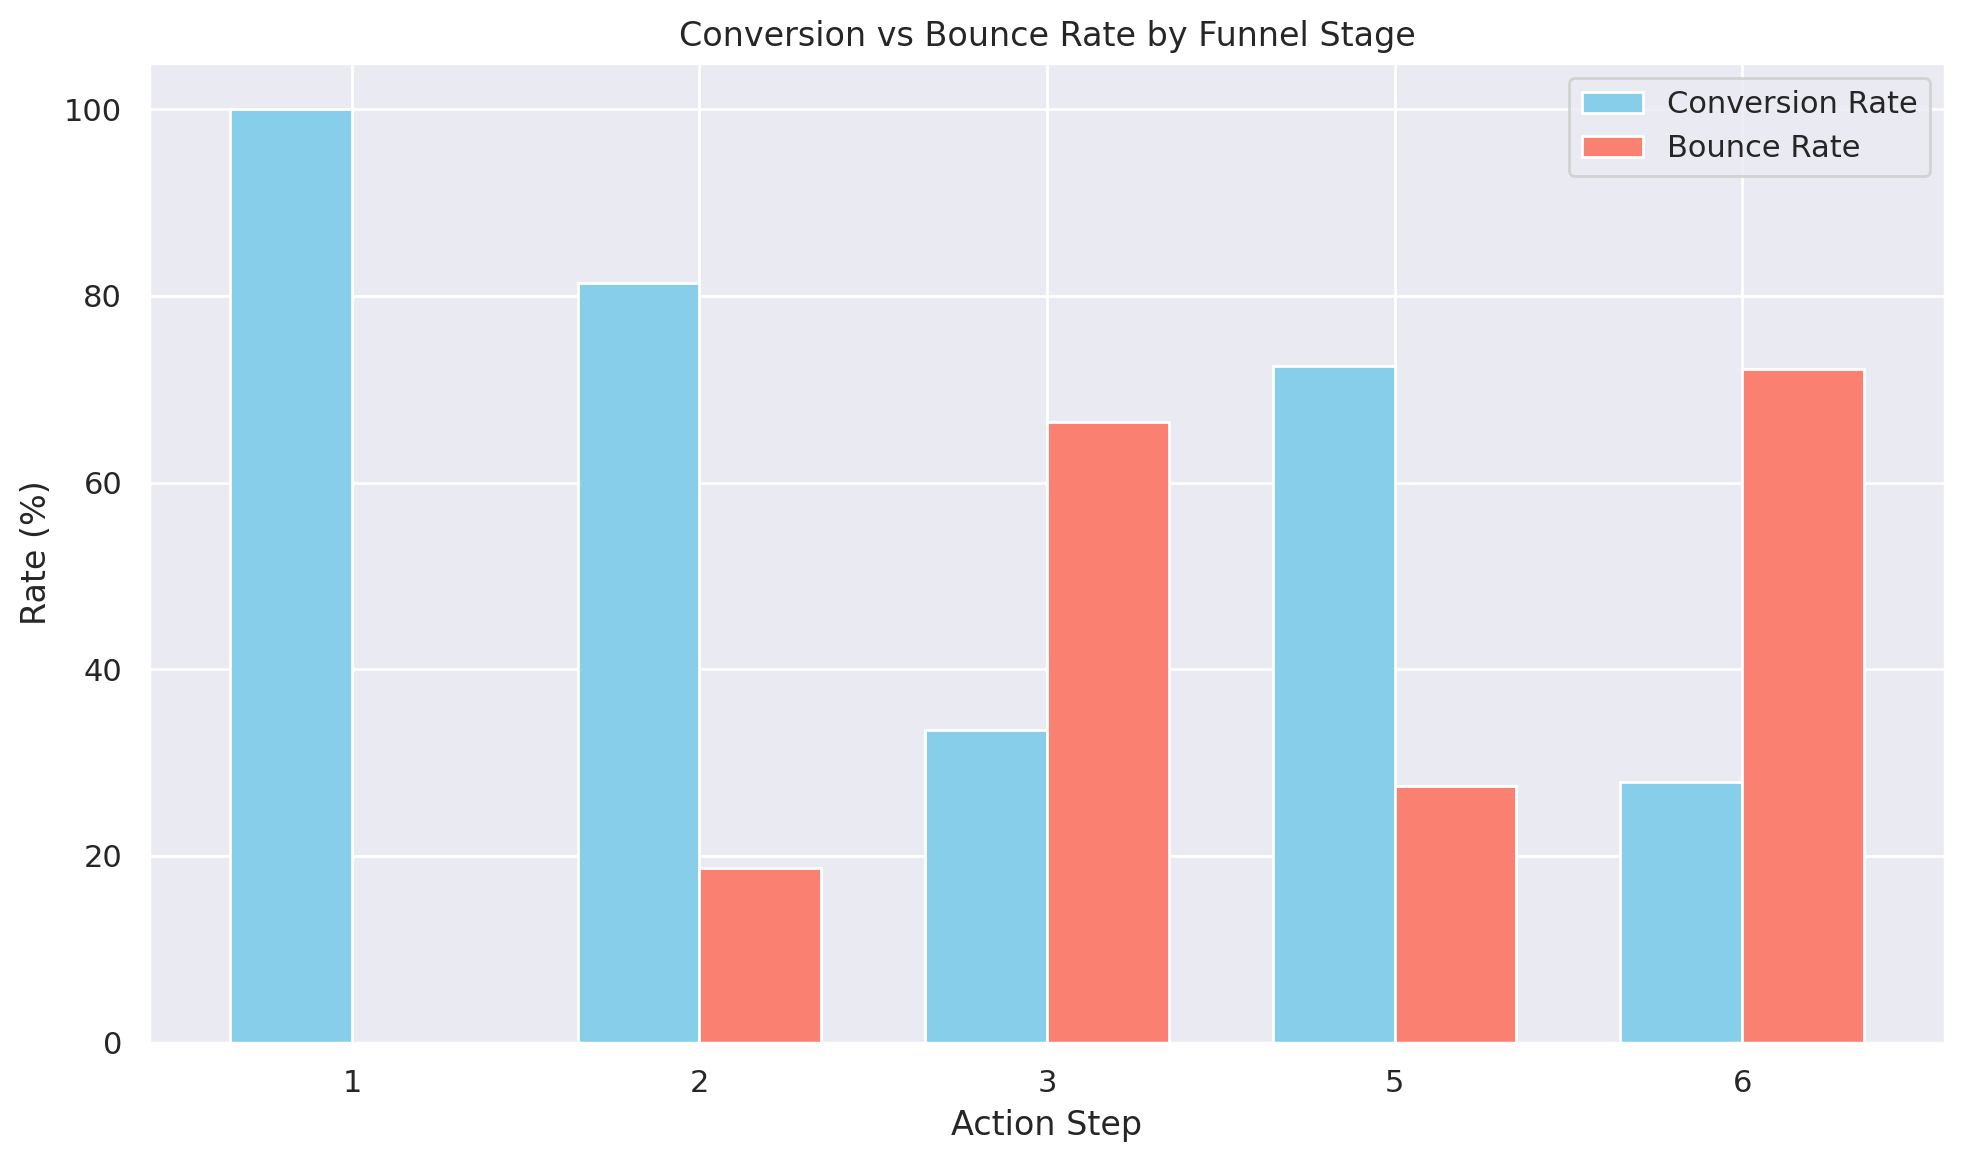

In [ ]:
## 전환율, 이탈율 산출

conversion_rate = [100]

for i in range(0,4):
  conversion_rate.append(round((x['count'].iloc[i+1]/x['count'].iloc[i])*100, 2))

x['conversion rate'] = conversion_rate
x['Bounce rate'] = np.repeat(100, 5) - np.array(conversion_rate)

## 전환율, 이탈율 시각화

labels = x['action'].astype(str)
conv = x['conversion rate']
bounce = x['Bounce rate']

x_pos = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x_pos - width/2, conv, width, label='Conversion Rate', color='skyblue')
plt.bar(x_pos + width/2, bounce, width, label='Bounce Rate', color='salmon')

plt.ylabel('Rate (%)')
plt.xlabel('Action Step')
plt.title('Conversion vs Bounce Rate by Funnel Stage')
plt.xticks(x_pos, labels)
plt.legend()
plt.tight_layout()
plt.show()


## 1-2. 신규 고객과 재방문 고객의 전환율 비교

- newVisits 컬럼을 기준으로 신규 고객과 재방문 고객을 구분하여 퍼널 단계별 세션 수 count

In [ ]:
## 신규 고객의 전환율

query = f"""
SELECT
  h.eCommerceAction.action_type AS action,
  COUNT(*) AS count
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS h
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND h.eCommerceAction.action_type IN ('1', '2', '3', '5', '6')
  AND totals.newVisits = 1
GROUP BY
  action
ORDER BY
  count DESC
"""

x = client.query(query).result().to_dataframe()

## 재방문 고객의 전환율
query = f"""
SELECT
  h.eCommerceAction.action_type AS action,
  COUNT(*) AS count
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS h
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND h.eCommerceAction.action_type IN ('1', '2', '3', '5', '6')
  AND totals.newVisits IS NULL
GROUP BY
  action
ORDER BY
  count DESC
"""

y = client.query(query).result().to_dataframe()

# 퍼널 차트 시각화
## 신규 고객
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'

def add_conversion_rate(df):
    df = df.sort_values("count", ascending=False).reset_index(drop=True)
    df["conv_rate"] = df["count"] / df["count"].iloc[0] * 100
    # 텍스트: 천 단위 콤마 + 줄바꿈 + 전환율
    df["label"] = df.apply(lambda row: f"{row['count']:,}<br>({row['conv_rate']:.1f}%)", axis=1)
    return df

# 신규 고객
x_conv = add_conversion_rate(x)

fig = go.Figure(go.Funnel(
    y=x_conv['action'],
    x=x_conv['count'],
    texttemplate='%{text}',
    text=x_conv['label'],
    textposition="inside",
    marker=dict(color='lightblue')
))

fig.update_layout(
    title='신규 고객 구매 전환 퍼널',
    plot_bgcolor='rgba(240,248,255,0.6)',
    yaxis_title="단계",
    xaxis_title="세션 수",
    font=dict(size=14)
)
fig.show()

# 재방문 고객
y_conv = add_conversion_rate(y)

fig = go.Figure(go.Funnel(
    y=y_conv['action'],
    x=y_conv['count'],
    texttemplate='%{text}',
    text=y_conv['label'],
    textposition="inside",
    marker=dict(color='lightblue')
))

fig.update_layout(
    title='재방문 고객 구매 전환 퍼널',
    plot_bgcolor='rgba(240,248,255,0.6)',
    yaxis_title="단계",
    xaxis_title="세션 수",
    font=dict(size=14)
)
fig.show()



## 1-3. 유입 경로별 퍼널 분석

- trafficSource.source, medium 컬럼을 기준으로 위와 동일하게 퍼널 분석, 그 중 상위 10개의 source_medium 조합을 확인하고 비교

In [ ]:
## 유입된 경로별 퍼널분석
query = f"""
SELECT
  hits.eCommerceAction.action_type AS action_type,
  trafficSource.source,
  trafficSource.medium,
  COUNT(DISTINCT fullVisitorId) AS users
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801' AND
  hits.eCommerceAction.action_type IN ('1','2','3','5','6')
GROUP BY
  action_type,
  source,
  medium
ORDER BY
  users DESC
"""
x = client.query(query).result().to_dataframe()

x['source_medium'] = x['source'] + ' / ' + x['medium']

# 상위 10개 source_medium 기준 필터링
top10_sources = x.groupby('source_medium')['users'].sum().nlargest(10).index
filtered = x[x['source_medium'].isin(top10_sources)]

conversion_data = []

for sm in top10_sources:
    temp = filtered[filtered['source_medium'] == sm].sort_values('action_type')

    if temp.empty:
        continue

    base_users = temp[temp['action_type'] == temp['action_type'].min()]['users'].sum()

    if base_users == 0:
        continue

    temp = temp.copy()
    temp['conversion_rate'] = temp['users'] / base_users
    temp['source_medium'] = sm
    conversion_data.append(temp)

conversion_df = pd.concat(conversion_data, ignore_index=True)

heatmap_df = conversion_df.pivot(index='source_medium', columns='action_type', values='conversion_rate').fillna(0)

fig = px.imshow(
    heatmap_df,
    text_auto='.0%',
    color_continuous_scale='Blues',
    aspect='auto',
    title='Source/Medium vs 퍼널 단계 전환율 히트맵'
)

fig.update_layout(
    xaxis_title='퍼널 단계',
    yaxis_title='소스 / 미디엄',
    font=dict(size=12)
)

fig.show()


In [ ]:
## 유입된 경로별 퍼널분석
query = f"""
SELECT
  hits.eCommerceAction.action_type AS action_type,
  trafficSource.source,
  trafficSource.medium,
  COUNT(*) AS users
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801' AND
  hits.eCommerceAction.action_type IN ('1','2','3','5','6')
GROUP BY
  action_type,
  source,
  medium
ORDER BY
  users DESC
"""
x = client.query(query).result().to_dataframe()

x['source_medium'] = x['source'] + ' / ' + x['medium']

# 상위 20개 source_medium 기준 필터링
top20_sources = x.groupby('source_medium')['users'].sum().nlargest(20).index
filtered = x[x['source_medium'].isin(top20_sources)]

conversion_data = []
base_users_dict = {}

for sm in top20_sources:
    temp = filtered[filtered['source_medium'] == sm].sort_values('action_type')
    if temp.empty:
        continue

    base_users = temp[temp['action_type'] == temp['action_type'].min()]['users'].sum()
    if base_users == 0:
        continue

    base_users_dict[sm] = base_users

    temp = temp.copy()
    temp['conversion_rate'] = temp['users'] / base_users
    temp['source_medium'] = sm
    conversion_data.append(temp)

# conversion_df 생성
conversion_df = pd.concat(conversion_data, ignore_index=True)

# 전체 세션 수 붙이기
conversion_df['source_medium_with_n'] = conversion_df['source_medium'].apply(
    lambda sm: f"{sm} ({base_users_dict.get(sm, 0):,})"
)

# 피벗테이블 생성
heatmap_df = conversion_df.pivot(
    index='source_medium_with_n',
    columns='action_type',
    values='conversion_rate'
).fillna(0)

# 전체 세션 수 기준 내림차순 정렬
heatmap_df = heatmap_df.loc[
    sorted(
        heatmap_df.index,
        key=lambda x: int(x.split('(')[-1].replace('N=', '').replace(')', '').replace(',', '')),
        reverse=True
    )
]

# 시각화
fig = px.imshow(
    heatmap_df,
    text_auto='.0%',
    color_continuous_scale='Blues',
    aspect='auto',
    title='Source/Medium vs 퍼널 단계 전환율 히트맵'
)

fig.update_layout(
    xaxis_title='퍼널 단계',
    yaxis_title='소스 / 미디엄 (전체 세션 수)',
    font=dict(size=12)
)

fig.show()


In [ ]:
# --- Referral medium 기반 퍼널 분석 ---

DATE_FROM = '20160801'
DATE_TO   = '20170801'
FUNNEL_STEPS = ['1','2','3','5','6']

query = f"""
SELECT
  hits.eCommerceAction.action_type AS action_type,
  channelGrouping,
  trafficSource.source,
  trafficSource.medium,
  COUNT(*) AS users
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
     UNNEST(hits) AS hits
WHERE _TABLE_SUFFIX BETWEEN '{DATE_FROM}' AND '{DATE_TO}'
  AND hits.eCommerceAction.action_type IN ('1','2','3','5','6')
  AND trafficSource.medium = 'referral'
GROUP BY action_type, channelGrouping, source, medium
ORDER BY users DESC
"""
x = client.query(query).result().to_dataframe()

# 라벨링: channelGrouping + source
x['channelGrouping'] = x['channelGrouping'].fillna('(not set)')
x['source'] = x['source'].fillna('(not set)')
x['channelGrouping_source'] = x['channelGrouping'] + ' / ' + x['source']

# 상위 10개 선택
top10 = (
    x.groupby('channelGrouping_source')['users']
     .sum()
     .nlargest(15)
     .index
)
filtered = x[x['channelGrouping_source'].isin(top10)].copy()

# action_type 순서 고정
filtered['action_type'] = pd.Categorical(
    filtered['action_type'].astype(str),
    categories=FUNNEL_STEPS,
    ordered=True
)

# 전환율 계산
conversion_data = []
for sm in top10:
    temp = filtered[filtered['channelGrouping_source'] == sm].sort_values('action_type')
    if temp.empty:
        continue
    base_step = temp['action_type'].min()
    base_users = temp.loc[temp['action_type'] == base_step, 'users'].sum()
    if base_users == 0:
        continue
    t = temp.copy()
    t['conversion_rate'] = t['users'] / base_users
    t['channelGrouping_source'] = sm
    conversion_data.append(t)

conversion_df = pd.concat(conversion_data, ignore_index=True)

# 총 사용자수 붙이기
total_users = (
    filtered.groupby('channelGrouping_source')['users']
    .sum()
    .reset_index()
    .rename(columns={'users':'total_users'})
)

# 히트맵용 피벗
heatmap_df = (
    conversion_df.pivot(index='channelGrouping_source', columns='action_type', values='conversion_rate')
    .reindex(columns=FUNNEL_STEPS)
    .fillna(0)
    .merge(total_users, on='channelGrouping_source')
    .sort_values('total_users', ascending=False)
)

# y축 레이블에 (n=) 붙이기
heatmap_df.index = heatmap_df['channelGrouping_source'] + ' (' + heatmap_df['total_users'].astype(str) + ')'
heatmap_df = heatmap_df.drop(columns=['channelGrouping_source','total_users'])

# 시각화
fig = px.imshow(
    heatmap_df,
    text_auto='.0%',
    color_continuous_scale='Oranges',
    aspect='auto',
    title='ChannelGrouping / Source vs 퍼널 단계 전환율 (medium=referral)'
)
fig.update_layout(
    xaxis_title='퍼널 단계',
    yaxis_title='ChannelGrouping / Source (전체 사용자 수)',
    font=dict(size=12)
)
fig.show()


# 2. 퍼널별 체류시간 분석

## 2-1. 퍼널 단계별 평균 체류시간

- 현재 세션 max(hits.time) - 전 세션 max(hits.time)을 하여 퍼널 단계별 평균 체류시간 계산
- session_hits CTE
  - 세션별 max(hits.time)을 계산하여 고객별 총 체류시간을 계산
- action_time_diff CTE
  - lag함수를 이용하여 현재 퍼널의 전 퍼널까지의 max_hit_time 계산
- 최종 SELECT
  - '현재 세션의 총 체류시간에서 - 직전 세션의 총 체류시간'을 구한 뒤 그 값들의 평균


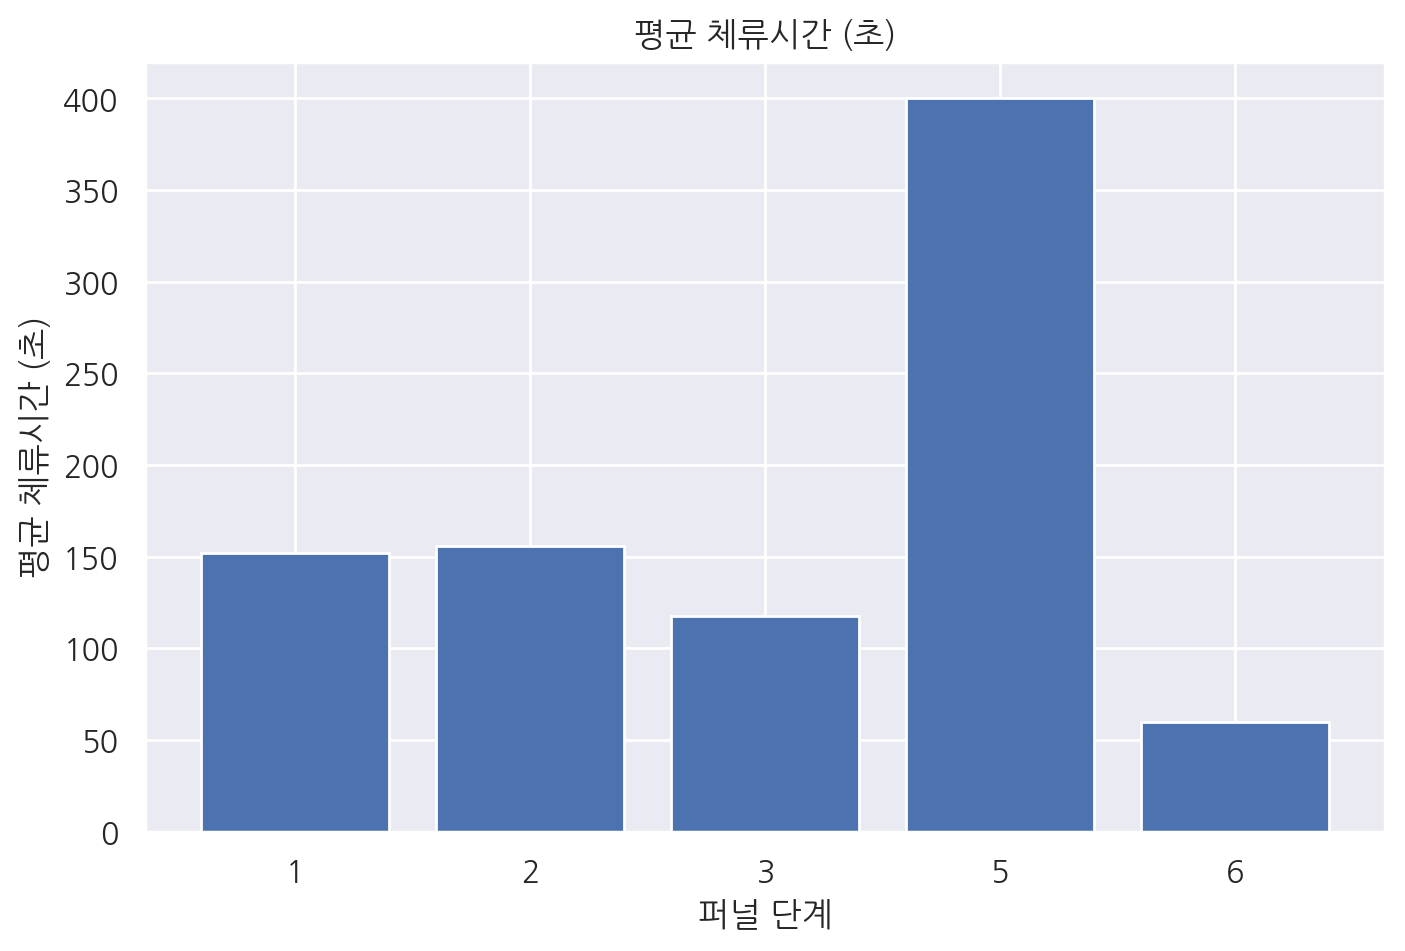

In [ ]:
## 퍼널 단계별 평균 체류시간
query = f"""
WITH session_hits AS (
  SELECT
    fullVisitorId,
    visitId,
    hits.eCommerceAction.action_type AS action_type,
    MAX(hits.time) / 1000 AS max_hit_time --hits.time 기준으로 세션마다 최댓값
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.eCommerceAction.action_type IS NOT NULL
    AND hits.eCommerceAction.action_type IN ('1', '2', '3', '5', '6')  -- 문자열 비교
  GROUP BY
    fullVisitorId, visitId, action_type
),

action_time_diff AS (
  SELECT
    fullVisitorId,
    visitId,
    action_type,
    max_hit_time,
    LAG(max_hit_time) OVER (PARTITION BY fullVisitorId, visitId ORDER BY max_hit_time) AS prev_max_hit_time -- 전 퍼널의 max_hit_time
  FROM
    session_hits
)

SELECT
  action_type,
  COUNT(*) AS session_count,
  ROUND(AVG(COALESCE(max_hit_time - prev_max_hit_time, max_hit_time)), 2) AS avg_duration_sec -- 현재 퍼널의 max_hit_time - 전 퍼널의 max_hit_time의 평균값
FROM
  action_time_diff
GROUP BY
  action_type
ORDER BY
  avg_duration_sec DESC

"""
x = client.query(query).result().to_dataframe()


# 원하는 순서대로 정렬
order = ['1','2', '3', '5','6']
x_sorted = x.set_index('action_type').loc[order].reset_index()

plt.figure(figsize=(8,5))
plt.bar(range(len(x_sorted)), x_sorted['avg_duration_sec'])

# x축 눈금 위치와 숫자 레이블 지정
plt.xticks(ticks=range(len(order)), labels=order)

plt.title('평균 체류시간 (초)')
plt.xlabel('퍼널 단계')
plt.ylabel('평균 체류시간 (초)')

plt.show()

## 2-2. 체류시간이 구매 전환에 끼치는 영향

- action_type 발생 순서를 확인
- actions CTE
  - fullVisitorId, visitId로 묶어서 hits.time을 기준으로 발생한 action_type의 순서를 매김
- 최종 SELECT
  - 각 발생 순서가 얼마나 발생했는지 세션 수를 count

In [ ]:
# 1단계 : action_type 시퀀스 분석

query = f"""
WITH actions AS (
  SELECT
    fullVisitorId,
    visitId,
    ARRAY_AGG(h.eCommerceAction.action_type ORDER BY h.time) AS action_sequence
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS h
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
    AND h.eCommerceAction.action_type IS NOT NULL
  GROUP BY
    fullVisitorId, visitId
)

SELECT
  action_sequence,
  COUNT(*) AS session_count
FROM
  actions
GROUP BY
  action_sequence
ORDER BY
  session_count DESC
LIMIT 20
"""
x = client.query(query).result().to_dataframe()
x

,action_sequence,session_count
0,[0],36047
1,"[0, 0]",9609
2,"[0, 0, 0]",5330
3,"[0, 0, 0, 0]",3026
4,"[0, 0, 0, 0, 0]",1864
5,"[0, 0, 0, 0, 0, 0]",1253
6,"[0, 0, 0, 0, 0, 0, 0]",865
7,"[0, 0, 0, 0, 0, 0, 0, 0]",573
8,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",386
9,"[0, 1, 2]",377


- 위에서 액션타입이 대부분 0,1,2 위주로 발생하기 때문에 액션 타입이 1,2,3,5,6인 경우만 가져옴
- sessions_with_actions CTE
  - 액션 타입 + hit_time
- ordered_actions CTE
  - hit_time을 기준으로 액션 타입 순서를 나열하여 확인
- 최종 SELECT
  - 각 액션 순서 별로 세션을 count하여 발생 빈도 확인

In [ ]:
## 디버깅
## hits.time 기준으로 action_type 순서 확인하기

query = f"""
WITH sessions_with_actions AS (
  SELECT
    fullVisitorId,
    visitStartTime,
    hits.eCommerceAction.action_type AS action_type,
    hits.time AS hit_time
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX = '20170101'
    AND hits.eCommerceAction.action_type IN ('1', '2', '3', '5', '6')
),

ordered_actions AS (
  SELECT
    fullVisitorId,
    visitStartTime,
    ARRAY_AGG(CAST(action_type AS INT64) ORDER BY hit_time) AS action_type_sequence
  FROM
    sessions_with_actions
  GROUP BY
    fullVisitorId, visitStartTime
)

SELECT
  action_type_sequence,
  COUNT(*) AS session_count
FROM
  ordered_actions
GROUP BY
  action_type_sequence
ORDER BY
  session_count DESC
LIMIT 50


"""
x = client.query(query).result().to_dataframe()
x


,action_type_sequence,session_count
0,"[1, 2]",36
1,"[2, 1]",11
2,"[1, 2, 1, 2]",6
3,"[2, 1, 1]",5
4,"[1, 2, 1, 2, 1, 2, 1, 2]",4
5,"[1, 2, 1, 1, 2, 1]",3
6,"[2, 1, 1, 2]",3
7,"[2, 1, 3]",3
8,"[1, 2, 1, 2, 1]",3
9,"[1, 2, 1, 2, 1, 2, 3]",2


- 퍼널 단계별 체류시간이 수익 유무에 영향을 주는지 확인
- step_duration CTE
  - 단계 구간별 체류시간 계산 (1,2,3,5,6 순으로 진행된다는 가정)
- session_purchase CTE
  - 수익 유무 컬럼 생성
- session_data CTE
  - step_duration + session_purchase
- 최종 SELECT
  - 0-3분, 3-6분, 6-9분과 같은 방식으로 구간화하여 수익 유무와 연결함
  - time_slot 그룹별로 구매 여부별 세션 수 집계

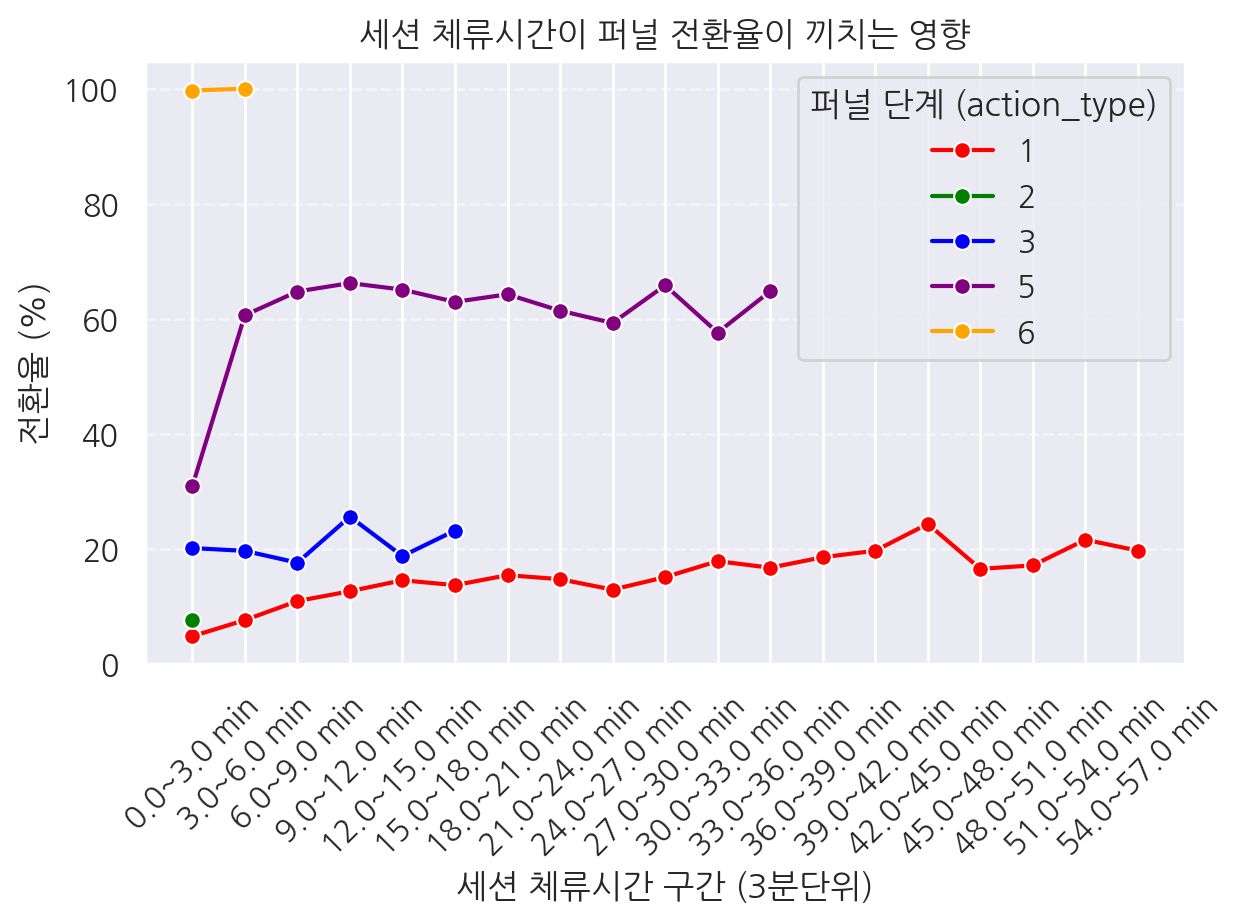

In [ ]:
query = f"""
WITH session_hits AS (
  SELECT
    fullVisitorId,
    visitStartTime,
    hits.eCommerceAction.action_type AS action_type,
    MAX(hits.time) AS max_time_ms  -- 각 action_type 별 마지막 히트 시간 (ms)
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.eCommerceAction.action_type IN ('1', '2', '3', '5', '6')
  GROUP BY
    fullVisitorId,
    visitStartTime,
    action_type
),

action_time_diff AS (
  SELECT
    fullVisitorId,
    visitStartTime,
    action_type,
    max_time_ms,
    LAG(max_time_ms) OVER (PARTITION BY fullVisitorId, visitStartTime ORDER BY CAST(action_type AS INT64)) AS prev_max_time_ms
  FROM
    session_hits
),

step_duration AS (
  SELECT
    fullVisitorId,
    visitStartTime,
    action_type,
    -- 이전 단계 시간보다 작으면 0으로 처리, 단위 초 변환
    GREATEST(0, (max_time_ms - IFNULL(prev_max_time_ms, 0))) / 1000 AS step_duration_sec -- 퍼널이 항상 1,2,3,5,6 순으로 진행되지 않아 체류시간이 음수가 되는 것을 방지하여 0 처리
  FROM
    action_time_diff
),

session_purchase AS (
  SELECT
    fullVisitorId,
    visitStartTime,
    MAX(totals.totalTransactionRevenue) AS total_revenue,
    CASE WHEN MAX(totals.totalTransactionRevenue) > 0 THEN 1 ELSE 0 END AS is_purchase -- 수익이 있는지를 기준으로 구매 전환 유무 판단
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId,
    visitStartTime
),

session_data AS (
  SELECT
    sd.fullVisitorId,
    sd.visitStartTime,
    sd.action_type,
    sd.step_duration_sec,
    sp.is_purchase
  FROM
    step_duration AS sd
  JOIN
    session_purchase AS sp
  ON sd.fullVisitorId = sp.fullVisitorId AND sd.visitStartTime = sp.visitStartTime
)

SELECT
  action_type,
  FLOOR(step_duration_sec / 180) AS time_slot,  -- 180초 = 3분 구간 / 구간 지정
  COUNT(DISTINCT CONCAT(fullVisitorId, CAST(visitStartTime AS STRING))) AS total_sessions,
  COUNT(DISTINCT CASE WHEN is_purchase = 1 THEN CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) END) AS purchases,
  SAFE_DIVIDE(
    COUNT(DISTINCT CASE WHEN is_purchase = 1 THEN CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) END),
    COUNT(DISTINCT CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)))
  ) AS conversion_rate -- 전체 세션 중 구매를 한 세션의 비율(세션 전환율)
FROM
  session_data
GROUP BY
  action_type,
  time_slot
ORDER BY
  action_type,
  time_slot


"""
df = client.query(query).result().to_dataframe()

# Filter sessions with sufficient volume
df = df[df['total_sessions'] >= 100]

# Convert time_slot into readable range labels
df['time_range'] = df['time_slot'].apply(lambda x: f"{x*3}~{x*3+3} min")

# Convert conversion rate to percentage
df['conversion_rate_pct'] = df['conversion_rate'] * 100

# Ensure action_type is integer for proper sorting
df['action_type'] = df['action_type'].astype(int)

# time_range에서 시작 분(min)만 숫자로 뽑아서 필터링
df['start_min'] = df['time_range'].str.extract(r'(\d+)').astype(int)

# 21분 구간까지만 필터링 (21분 = 21~24분 구간 포함)
# df_filtered = df[df['start_min'] <= 21]

# action_type별로 색깔 지정 (예: 1=빨강, 2=초록, 3=파랑, 4=보라, 5=주황)
palette_colors = {
    1: 'red',
    2: 'green',
    3: 'blue',
    5: 'purple',
    6: 'orange'
}

# 그래프 그리기 (기존 코드에 df -> df_filtered로 바꾸기)
sns.lineplot(
    data=df,
    x='time_range',
    y='conversion_rate_pct',
    hue='action_type',
    marker='o',
    palette=palette_colors
)

plt.title('세션 체류시간이 퍼널 전환율이 끼치는 영향')
plt.xlabel('세션 체류시간 구간 (3분단위)')
plt.ylabel('전환율 (%)')
plt.xticks(rotation=45)
plt.legend(
    title='퍼널 단계 (action_type)',
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    borderaxespad=0,
    fontsize=10
)
plt.legend(title='퍼널 단계 (action_type)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 3. 이벤트 유형별 구매 전환율 차이

## 이벤트별 재방문율, 구매 전환율

- eventAction 컬럼을 기준으로 이벤트 행동 분류하여 구매 전환율과 재방문율을 집계

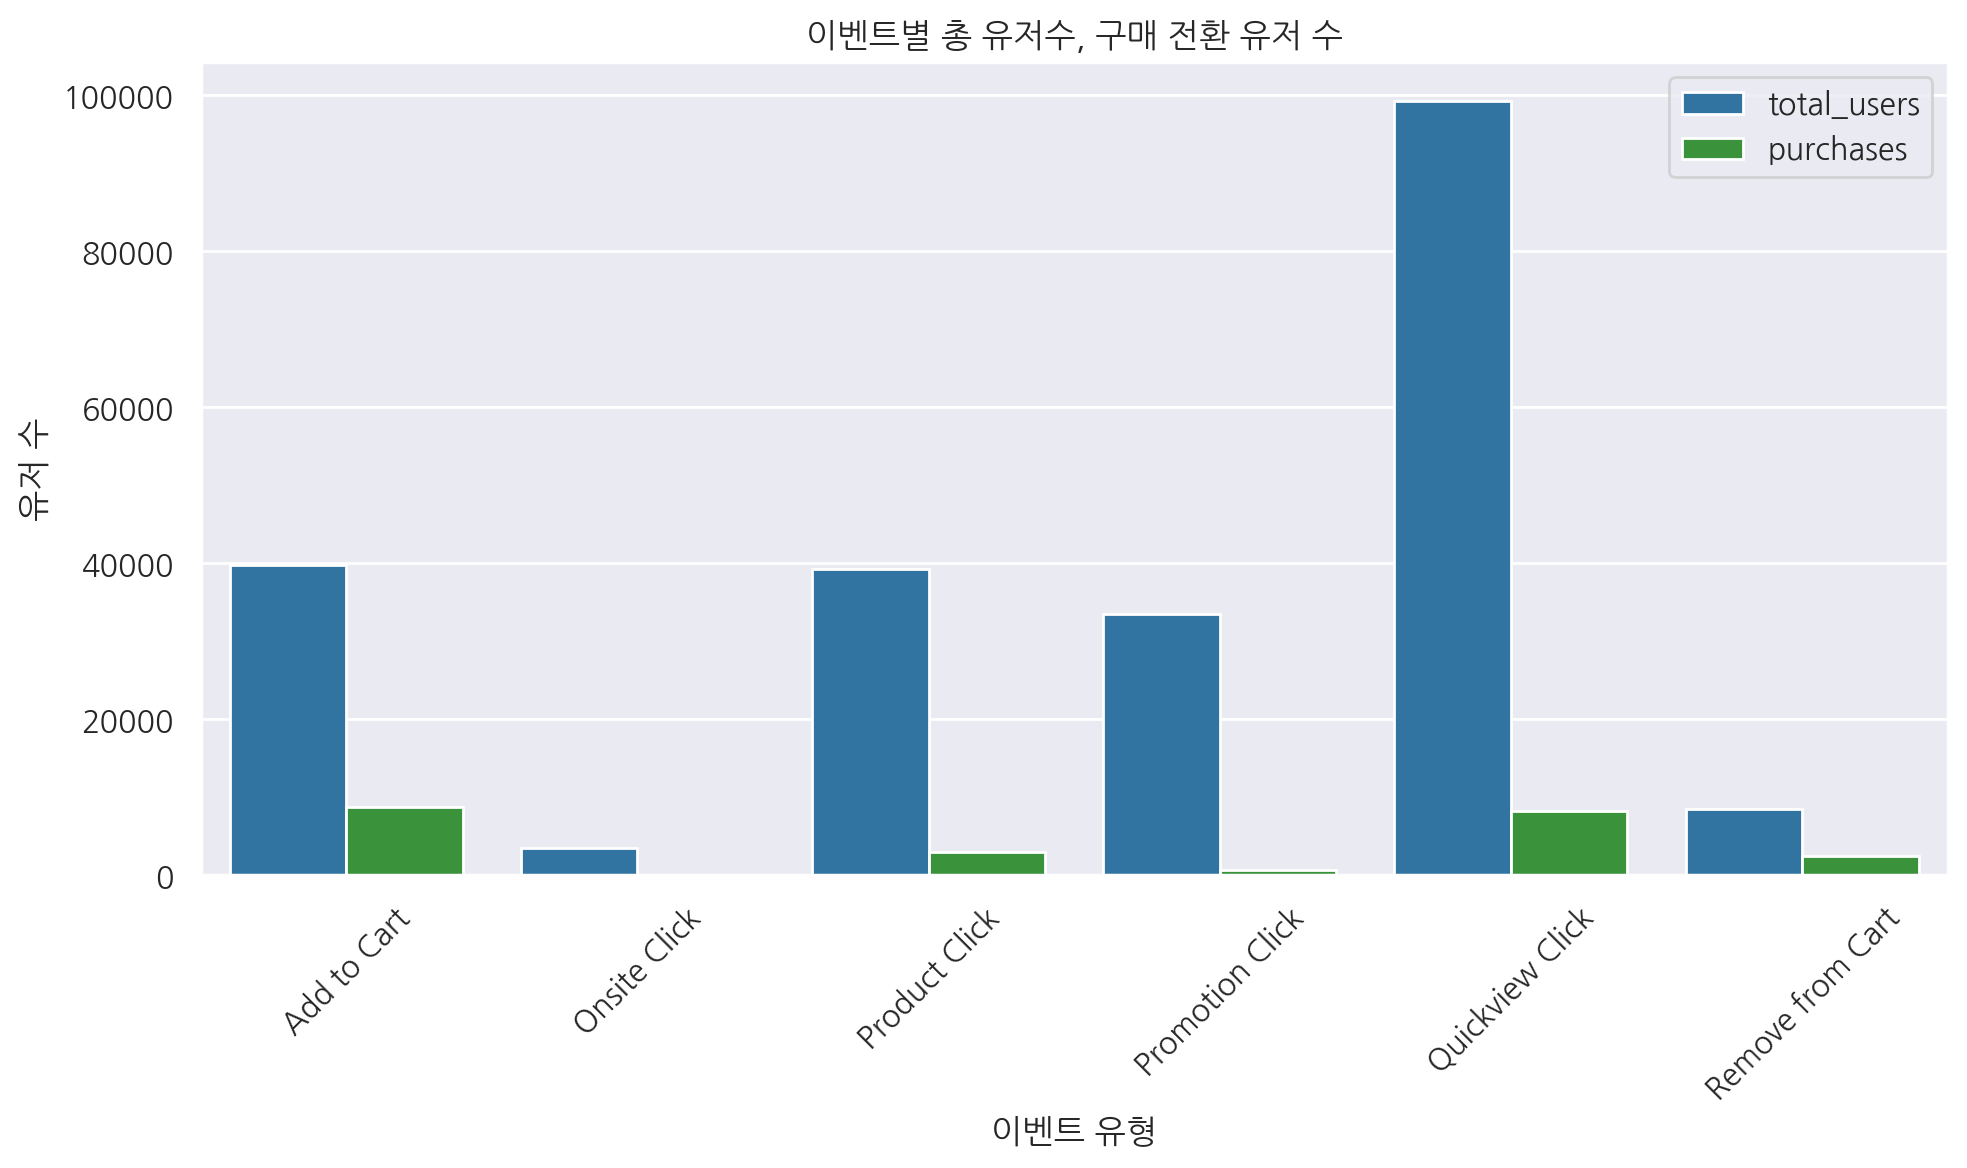

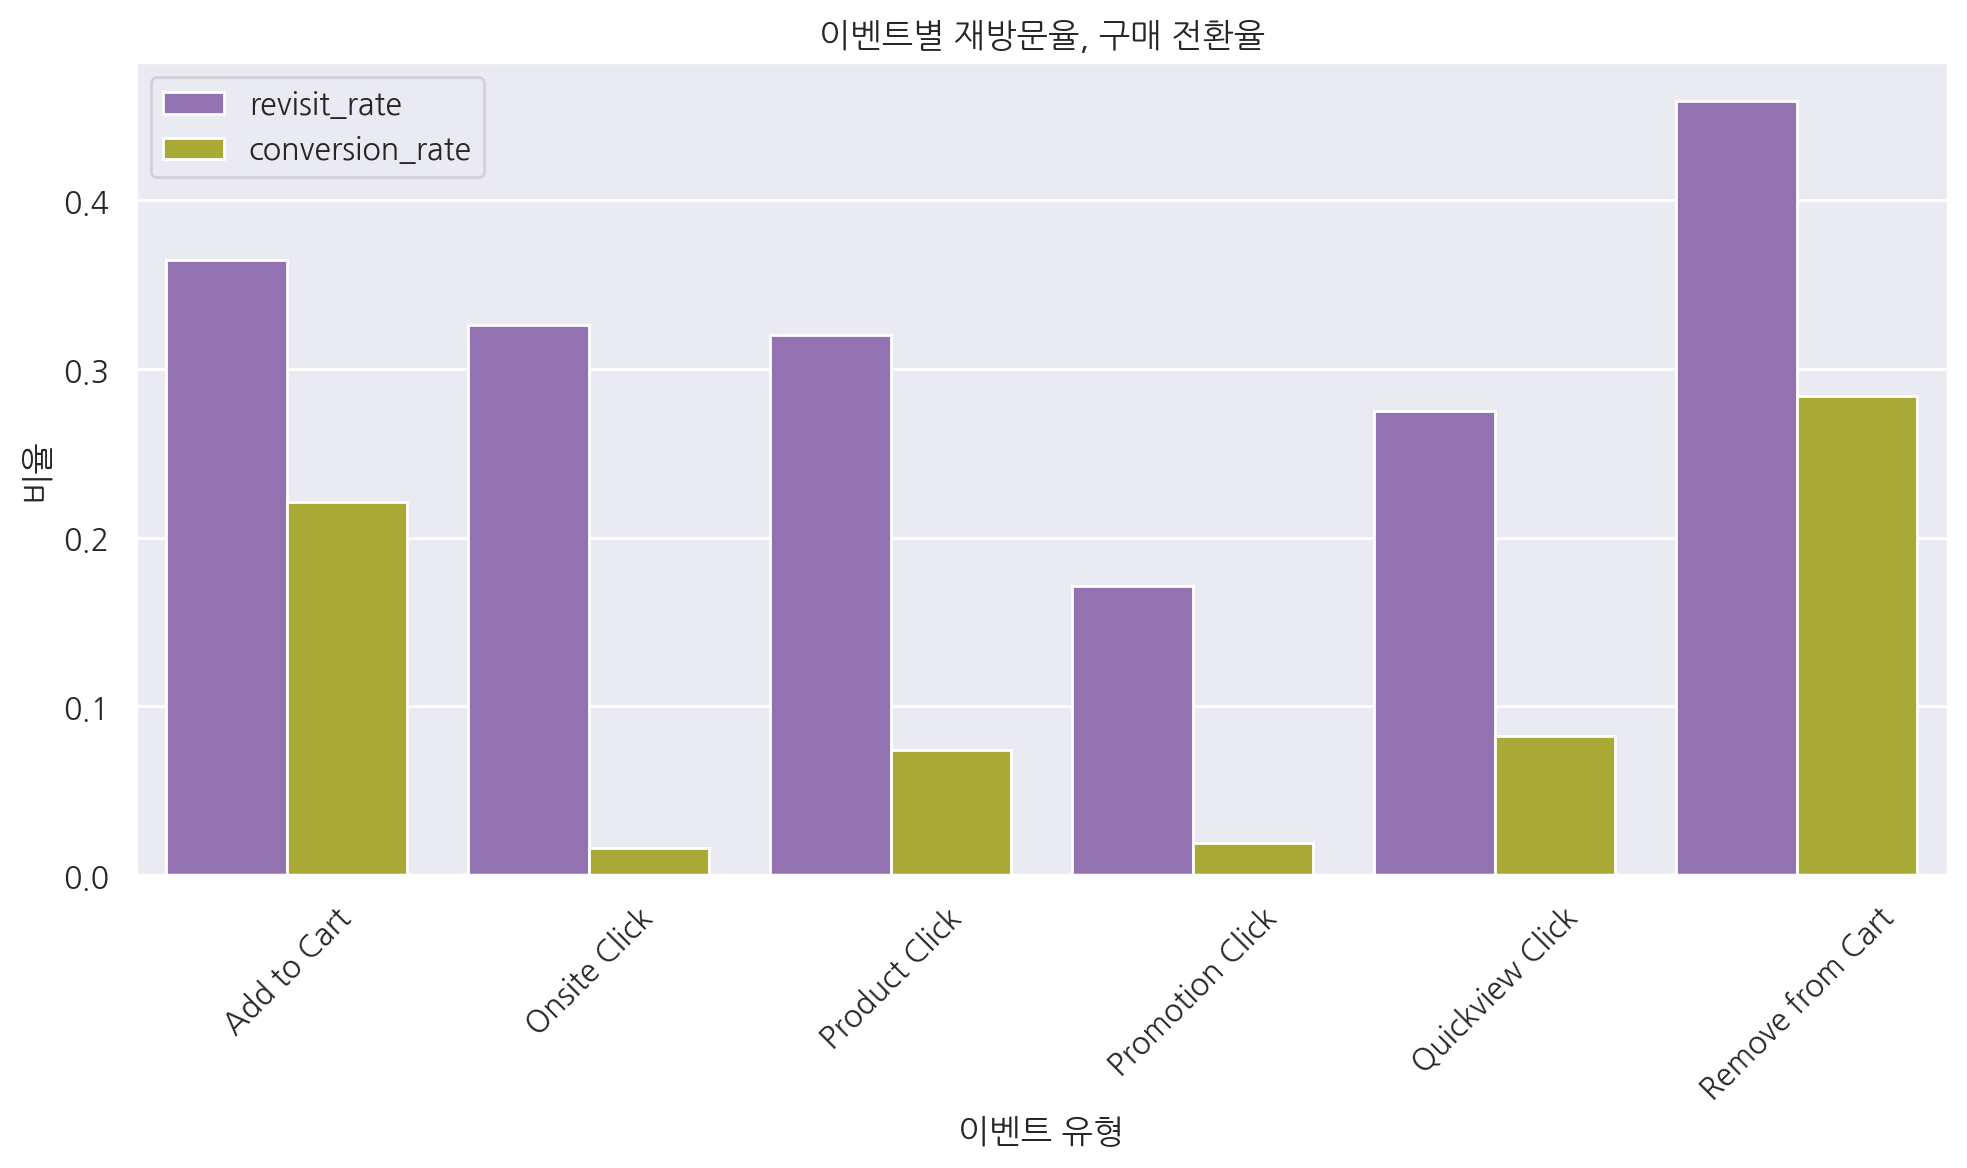

In [ ]:
query = f"""
SELECT
  hits.eventInfo.eventAction,
  fullVisitorId,
  CASE WHEN totals.transactions IS NOT NULL THEN 1 ELSE 0 END AS is_purchase,
  CASE WHEN totals.newVisits = 1 THEN 1 ELSE 0 END AS is_new_visitor
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
"""

# 액션 유형별 집계 (고유 유저 기준)
agg_df = (
    x.groupby('eventAction')
    .agg(
        total_users=('fullVisitorId', 'nunique'),
        purchases=('fullVisitorId', lambda v: v[x.loc[v.index, 'is_purchase'] == 1].nunique()),  # 구매한 유니크 유저 수
        revisit_users=('fullVisitorId', lambda v: v[x.loc[v.index, 'is_new_visitor'] == 0].nunique())  # 재방문 유니크 유저 수
    )
    .reset_index()
)
# 비율 계산
agg_df['conversion_rate'] = agg_df['purchases'] / agg_df['total_users']
agg_df['revisit_rate'] = agg_df['revisit_users'] / agg_df['total_users']

# 데이터 재구조화 (melt)
df1 = agg_df.melt(id_vars='eventAction', value_vars=['total_users', 'purchases'],
                  var_name='user_type', value_name='count')

plt.figure(figsize=(10,6))
sns.barplot(data=df1, x='eventAction', y='count', hue='user_type',
            palette=['#1f77b4', '#2ca02c'])
plt.title('이벤트별 총 유저수, 구매 전환 유저 수')
plt.xlabel('이벤트 유형')
plt.ylabel('유저 수')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.show()

# 비율 데이터 melt
df2 = agg_df.melt(id_vars='eventAction', value_vars=['revisit_rate', 'conversion_rate'],
                  var_name='rate_type', value_name='rate')

plt.figure(figsize=(10,6))
sns.barplot(data=df2, x='eventAction', y='rate', hue='rate_type',
            palette=['#9467bd', '#bcbd22'])
plt.title('이벤트별 재방문율, 구매 전환율')
plt.xlabel('이벤트 유형')
plt.ylabel('비율')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.show()


# 4. 전환 유저와 이탈 유저의 사용자 행동 분석

## 4-1. 전환 유저와 이탈 유저의 유입 경로 분석

- 이벤트별 재방문율, 전환율

In [ ]:
query="""
SELECT
    hits.eventInfo.eventAction AS Action,
    count(*) as count
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
GROUP BY
    Action
    """
eventCategory= client.query(query).result().to_dataframe()
eventCategory

,Action,count
0,Product Click,86198
1,Promotion Click,53432
2,Quickview Click,359494
3,Onsite Click,6348
4,None,3509925
5,Remove from Cart,16941
6,Add to Cart,121337


- totals.bounce값이 1인 게 non-interaction 상태인지 검증
  - bounces = 0일때 : 평균 hit 8.16 -> 추가적인 상호작용이 있었음을 의미
  - bounces = 1일때 : 평균 hit 1.00 -> 한번의 hit만 발생하고 종료된 세션임을 의미



In [ ]:
## 이벤트가 non-interaction 인지 검증
query = f"""
SELECT
  totals.bounces,
  COUNT(*) AS sessions,
  SUM(ARRAY_LENGTH(hits)) AS total_hits,
  AVG(ARRAY_LENGTH(hits)) AS avg_hits_per_session
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY
  totals.bounces
ORDER BY
  totals.bounces

"""
x = client.query(query).result().to_dataframe()
x

,bounces,sessions,total_hits,avg_hits_per_session
0,<NA>,453023,3699093,8.165354
1,1,450630,454582,1.008770


In [ ]:
## bounces 가 1일 때, action_type이 보통 0으로 나오기 때문에 정확히 측정하기 어려움
query = f"""
SELECT
  s.fullVisitorId,
  s.visitId,
  s.totals.bounces,
  s.totals.pageviews,
  s.trafficSource.source,
  s.trafficSource.medium,
  h.type AS hit_type,
  h.page.pagePath AS page_path,
  h.eventInfo.eventCategory AS event_category,
  h.eventInfo.eventAction AS event_action,
  h.eCommerceAction.action_type AS action_type
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS s,
  UNNEST(s.hits) AS h
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20160831'
  AND s.totals.bounces = 1
LIMIT 50;
"""
x = client.query(query).result().to_dataframe()
x


,fullVisitorId,visitId,bounces,pageviews,source,medium,hit_type,page_path,event_category,event_action,action_type
0,9203711028335521931,1470622100,1,1,google,organic,PAGE,/google+redesign/bags,None,None,0
1,0696773336104767519,1470603792,1,1,google,organic,PAGE,/google+redesign/bags,None,None,0
2,8339169457015057847,1470617273,1,1,google,organic,PAGE,/google+redesign/bags,None,None,0
3,5505314906775414967,1470590638,1,1,google,organic,PAGE,/google+redesign/electronics,None,None,0
4,9953392526764287787,1470590510,1,1,google,organic,PAGE,/google+redesign/office/notebooks++journals,None,None,0
5,4144336241819220513,1470628411,1,1,google,organic,PAGE,/google+redesign/apparel/headgear/youtube+truc...,None,None,0
6,3562563288004298263,1470574090,1,1,google,organic,PAGE,/store.html,None,None,0
7,693341557980363363,1470616159,1,1,google,organic,PAGE,/asearch.html,None,None,0
8,954767437398471302,1470559575,1,1,(direct),(none),PAGE,/google+redesign/bags,None,None,0
9,5393398810188371913,1470586676,1,1,google,organic,PAGE,/google+redesign/lifestyle,None,None,0


## 4-1. 사용자 이벤트 행동 분석

- hit number 1에서 전환이나 이탈하기 전에 했던 이벤트 행동 확인
- sessions CTE
  - 모든 fullVisitorId와 visitid의 조합
- session_actions CTE
  - 각 조합별 액션 타입 배열
- session_labels CTE
  - 액션 타입이 2,3,5,6인 경우 activate, 액션 타입이 4,7,8인 경우 other, 1이나 0인 경우 또는 그 외의 숫자는 bounce로 처리
- user_labels CTE
  - 조건으로 고객별 라벨 부여
- 최종 SELECT
  - hitnumber가 1인 조건으로 랜딩 이후 사용자 이벤트 행동 분석

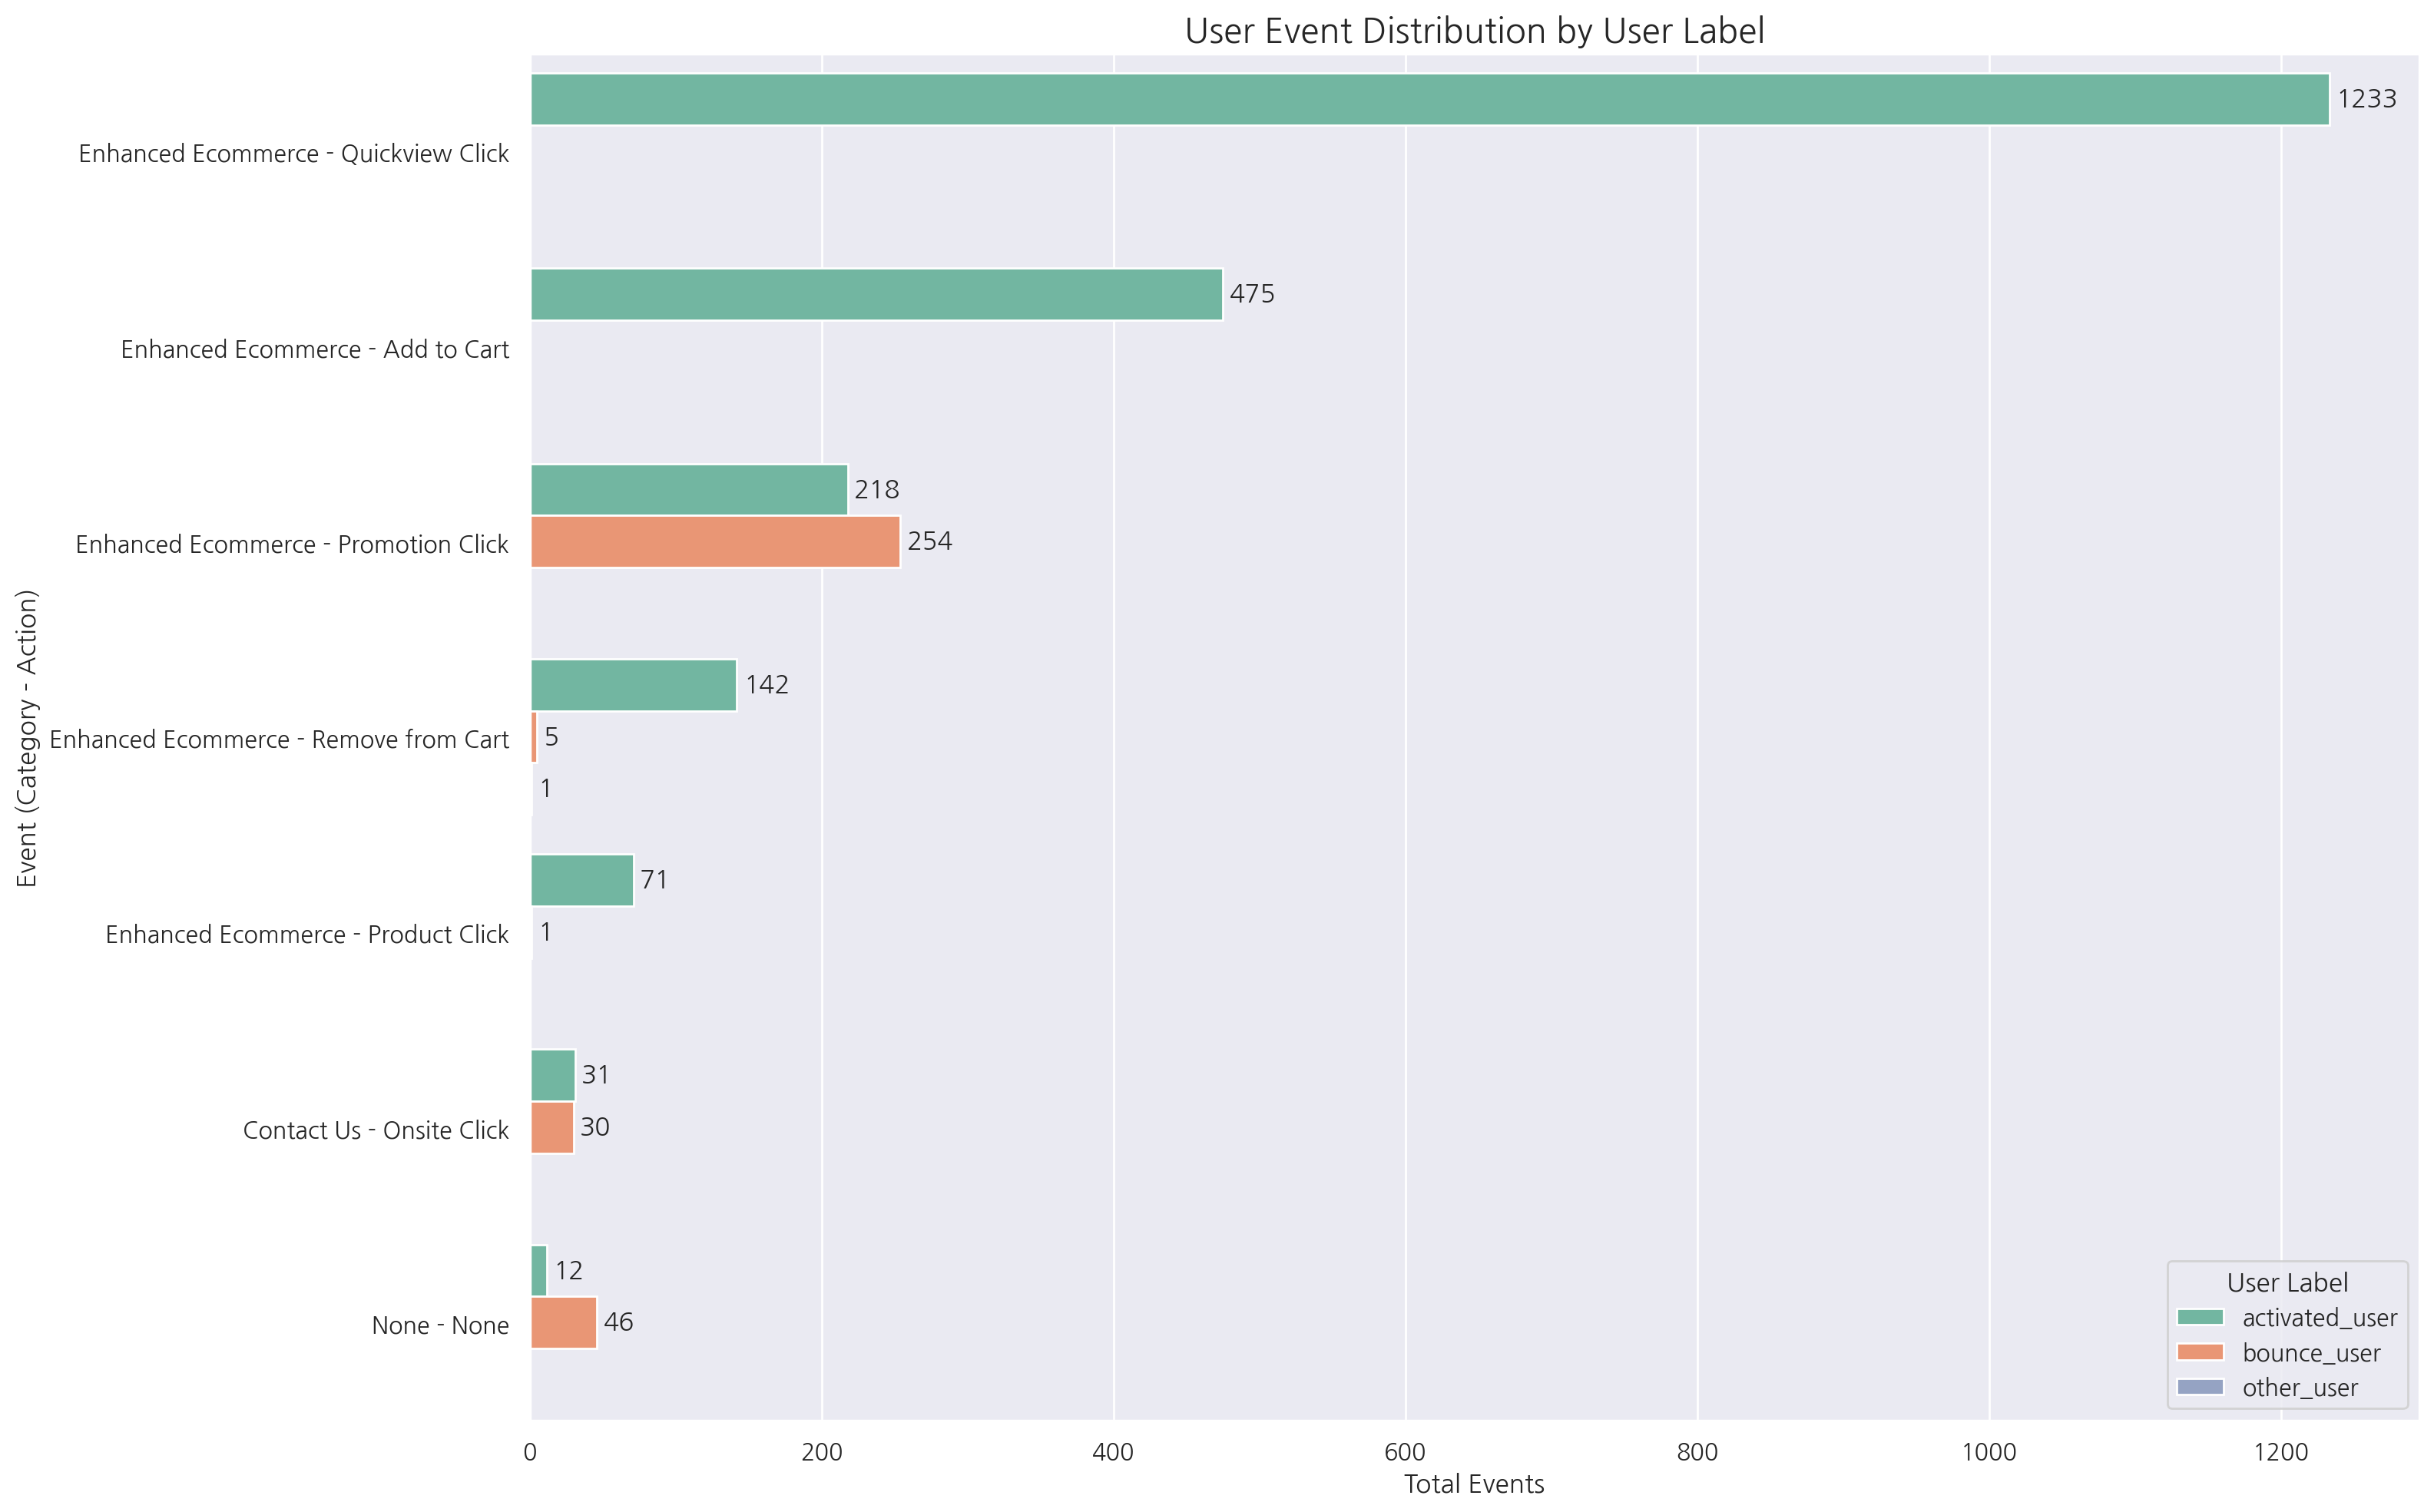

In [ ]:
## 이탈 유저와 전환 유저의 이벤트 행동

query = f"""
WITH sessions AS (
  SELECT
    fullVisitorId,
    visitId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
),

session_actions AS (
  SELECT
    fullVisitorId,
    visitId,
    ARRAY_AGG(DISTINCT hits.eCommerceAction.action_type IGNORE NULLS) AS action_types
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY fullVisitorId, visitId
),

session_labels AS (
  SELECT
    s.fullVisitorId,
    s.visitId,
    CASE
      WHEN EXISTS (SELECT 1 FROM UNNEST(sa.action_types) AS x WHERE x IN ('2','3','5','6')) THEN 'activated'
      WHEN EXISTS (SELECT 1 FROM UNNEST(sa.action_types) AS x WHERE x IN ('4','7','8')) THEN 'other'
      ELSE 'bounce'
    END AS session_label
  FROM sessions s
  LEFT JOIN session_actions sa
    ON s.fullVisitorId = sa.fullVisitorId
   AND s.visitId = sa.visitId
),

user_labels AS (
  SELECT
    fullVisitorId,
    CASE
      WHEN COUNTIF(session_label = 'activated') > 0 THEN 'activated_user'
      WHEN COUNTIF(session_label = 'bounce') > 0 THEN 'bounce_user'
      WHEN COUNTIF(session_label = 'other') > 0 THEN 'other_user'
      ELSE 'unknown_user'
    END AS user_label
  FROM session_labels
  GROUP BY fullVisitorId
)

SELECT
  u.user_label,
  h.eventInfo.eventCategory AS eventCategory,
  h.eventInfo.eventAction AS eventAction,
  COUNT(DISTINCT sess.fullVisitorId) AS users,
  COUNT(*) AS total_events
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS sess
JOIN
  user_labels AS u
ON
  sess.fullVisitorId = u.fullVisitorId
, UNNEST(sess.hits) AS h
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND h.type = 'EVENT'
  AND h.hitNumber =1
GROUP BY
  u.user_label,
  eventCategory,
  eventAction
ORDER BY
  u.user_label,
  total_events DESC

"""
x = client.query(query).result().to_dataframe()
x

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 이벤트 이름 통합
x["event_name"] = x["eventCategory"].fillna("None") + " - " + x["eventAction"].fillna("None")

# user_label별 이벤트 정렬 (total_events 내림차순)
x_sorted = x.sort_values(["user_label", "total_events"], ascending=[True, False])

plt.figure(figsize=(16,10))
ax = sns.barplot(
    data=x_sorted,
    x="total_events",
    y="event_name",
    hue="user_label",
    palette='Set2'
)

plt.title("User Event Distribution by User Label", fontsize=16)
plt.xlabel("Total Events")
plt.ylabel("Event (Category - Action)")

# 막대 위에 수치 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.legend(title="User Label")
plt.tight_layout()
plt.show()


# 5. 이탈한 고객의 재방문 후 전환율

## 5-1. 이탈 단계별 전환율

- 사용자의 최대 퍼널 진입 단계 파악

In [ ]:
query = f"""
SELECT
  fullVisitorID,
  -- 자료 타입을 변형하는 함수 : cast
  max(cast(hits.eCommerceAction.action_type as int64)) as max_action_type --1,2,5,6의 액션 타입 중 사용자의 최대 퍼널 진입 단계
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) as hits
WHERE
    _table_suffix between '20170701' and '20170715' AND -- 기준 기간
    hits.eCommerceAction.action_type in ('1', '2', '5', '6')
GROUP BY
  fullVisitorID
ORDER BY 2 DESC
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,fullVisitorID,max_action_type
0,5296297372596099151,6
1,403789659645595849,6
2,9784853758319873850,6
3,4274511861314211339,6
4,4119448635627172848,6
5,3891707253957252733,6
6,0014262055593378383,6
7,6310913035223827948,6
8,1835132804289989526,6
9,7701613595320832147,6


- 같은 사용자 ID 기준, 이후 날짜 범위 내에서 action_type = 6 이 발생한 유저 식별

In [ ]:
query = f"""
SELECT
    distinct fullVisitorID
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) as hits
WHERE
    _table_suffix between '20170716' and '20170801' AND -- 후속 관찰 기간
    hits.eCommerceAction.action_type  = '6'
ORDER BY 1
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,fullVisitorID
0,0006911334202687206
1,0010295111715775250
2,0024932550342595467
3,0047078955120420928
4,0080479763428955064
5,0082806901961150595
6,0097371986665596420
7,0126612099954375841
8,0128830210468179660
9,0143782636543876435


- 각 단계(이탈 구간)별 향후 전환율 계산
- max_funnel CTE
  - 액션타입이 1,2,5,6일 경우의 사용자의 최대 퍼널 진입 단계 파악
- retained_users CTE
  - 액션 타입이 6인 고객 (구매 전환된 고객)
- 최종 SELECT
  - 각 최대 도달 단계의 총 고객 중 구매 전환된 고객 비율을 확인

In [ ]:
# distinct X
query = f"""
WITH max_funnel AS (
    SELECT
      fullVisitorID,
      -- 자료 타입을 변형하는 함수 : cast
      max(cast(hits.eCommerceAction.action_type as int64)) as max_action_type
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE
        _table_suffix between '20170701' and '20170715' AND -- 기준 기간
        hits.eCommerceAction.action_type in ('1', '2', '5', '6')
    GROUP BY
      fullVisitorID
    ORDER BY 2 DESC
),
retained_users AS (
    SELECT
        distinct fullVisitorID
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE
        _table_suffix between '20170716' and '20170801' AND -- 후속 관찰 기간
        hits.eCommerceAction.action_type  = '6'
    ORDER BY 1
)

SELECT
  max_action_type,
  count(max_funnel.fullVisitorID) as total_users,
  count(retained_users.fullVisitorID) as retained_users,
  -- 안전하게 나누기 연산하기
  safe_divide(count(retained_users.fullVisitorID), count(max_funnel.fullVisitorID))*100 as retention_rate
-- 모든 유저를 유지하면서 해당 유저가 retrained_useers에도 있다면 전환 여부를 붙이기 위해서
FROM
  max_funnel left join retained_users using(fullVisitorID)
  -- on max_funnel.fullVisitorID = retained_users.fullVisitorID
GROUP BY max_action_type
ORDER BY 1
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,max_action_type,total_users,retained_users,retention_rate
0,1,19,0,0.000000
1,2,3569,38,1.064724
2,5,395,15,3.797468
3,6,412,23,5.582524


In [ ]:
fig = px.bar(
    result,
    x='max_action_type',
    y='retention_rate',
    text='retention_rate',
    labels={'max_action_type': '최대 퍼널 단계', 'retention_rate': '전환률 (%)'},
    title='퍼널 단계별 전환률 (%)'
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(yaxis_title='전환률 (%)', xaxis_title='퍼널 단계')
fig.show()

## 5-2. 이탈 단계별 평균 전환 소요일 수(min/max 포함)

- 사용자가 도달한 최대 퍼널 단계, 그리고 그 날짜 기록

In [ ]:
query = f"""
SELECT
  fullVisitorID,
  -- 자료 타입을 변형하는 함수 : cast
  max(cast(hits.eCommerceAction.action_type as int64)) as max_action_type,
  -- parse_date(파싱 날짜 형식, Column) : 문자열을 날짜(date)로 변환해주는 빅쿼리 함수
  max(parse_date('%Y%m%d', Date)) as max_funnel_date -- 최대 진입 퍼널 단계에 도달한 날짜
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) as hits
WHERE
    _table_suffix between '20170701' and '20170715' AND -- 기준 기간
    hits.eCommerceAction.action_type in ('1', '2', '5')
GROUP BY
  fullVisitorID
ORDER BY 2 DESC, 3 ASC
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,fullVisitorID,max_action_type,max_funnel_date
0,583197022015696631,5,2017-07-01
1,433391447474937086,5,2017-07-01
2,3490195001506941719,5,2017-07-01
3,4810982230502482011,5,2017-07-01
4,1681835310828752790,5,2017-07-01
5,394659042451366024,5,2017-07-01
6,5715643479952657374,5,2017-07-01
7,1915673494199966547,5,2017-07-01
8,0716854705961319198,5,2017-07-01
9,1615356021148667762,5,2017-07-01


- 후속 관찰 기간을 설정하여 그 기간동안 구매한 유저의 min(Date)를 활용하여 구매한 날짜 확인

In [ ]:
query = f"""
SELECT
    distinct fullVisitorID,
    min(parse_date('%Y%m%d', Date)) as purchase_date
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) as hits
WHERE
    _table_suffix between '20170716' and '20170801' AND -- 후속 관찰 기간
    hits.eCommerceAction.action_type  = '6'
GROUP BY fullVisitorID
ORDER BY 1
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,fullVisitorID,purchase_date
0,0006911334202687206,2017-07-18
1,0010295111715775250,2017-07-31
2,0024932550342595467,2017-07-22
3,0047078955120420928,2017-07-31
4,0080479763428955064,2017-07-21
5,0082806901961150595,2017-07-25
6,0097371986665596420,2017-07-28
7,0126612099954375841,2017-08-01
8,0128830210468179660,2017-07-17
9,0143782636543876435,2017-07-22


- 두 시점 간 일수 차이 (max(Date) - min(Date)) 를 계산하여 구매까지 얼마나 시간이 걸렸는지 확인

In [ ]:
# fullVisitorID별
query = f"""
WITH max_funnel AS (
    SELECT
      fullVisitorID,
      -- 자료 타입을 변형하는 함수 : cast
      max(cast(hits.eCommerceAction.action_type as int64)) as max_action_type,
      -- parse_date(파싱 날짜 형식, Column) : 문자열을 날짜(date)로 변환해주는 빅쿼리 함수
      max(parse_date('%Y%m%d', Date)) as max_funnel_date
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE
        _table_suffix between '20170701' and '20170715' AND -- 기준 기간
        hits.eCommerceAction.action_type in ('1', '2', '5', '6')
    GROUP BY
      fullVisitorID
    ORDER BY 2 DESC, 3 ASC
),
retained_users AS (
    SELECT
        distinct fullVisitorID,
        min(parse_date('%Y%m%d', Date)) as purchase_date
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE
        _table_suffix between '20170716' and '20170801' AND -- 후속 관찰 기간
        hits.eCommerceAction.action_type  = '6'
    GROUP BY fullVisitorID
    ORDER BY 1
)

SELECT
  fullVisitorID,
  max_action_type,
  -- Day : 단위 → 며칠 차이인지 계산
  date_diff(purchase_date, max_funnel_date, Day) as days_to_conversion
FROM
  max_funnel join retained_users using(fullVisitorID)
ORDER BY 3
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,fullVisitorID,max_action_type,days_to_conversion
0,5056841379210378275,2,1
1,0405996727678488611,2,1
2,2868753573471668678,2,2
3,8261368202596858055,5,2
4,2264010855758956307,2,2
5,7478106734160303595,5,3
6,6361004934465135812,5,3
7,9417857471295131045,6,3
8,9784853758319873850,6,3
9,8573628711430738315,5,4


- 두 시점 간 일수 차이 계산 + 각 단계별 평균, 최대, 최소 일수 구함
- mas_funnel CTE
  - 위와 동일
- retained_users CTE
  - 위와 동일
- 최종 SELECT
  - 액션 타입 별로 구매 날짜와 최대 퍼널 도달 날짜를 빼 평균 기간을 구함

In [ ]:
query = f"""
WITH max_funnel AS (
    SELECT
      fullVisitorID,
      -- 자료 타입을 변형하는 함수 : cast
      max(cast(hits.eCommerceAction.action_type as int64)) as max_action_type,
      -- parse_date(파싱 날짜 형식, Column) : 문자열을 날짜(date)로 변환해주는 빅쿼리 함수
      max(parse_date('%Y%m%d', Date)) as max_funnel_date
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE
        _table_suffix between '20170701' and '20170715' AND -- 기준 기간
        hits.eCommerceAction.action_type in ('1', '2', '5', '6')
    GROUP BY
      fullVisitorID
    ORDER BY 2 DESC, 3 ASC
),
retained_users AS (
    SELECT
        distinct fullVisitorID,
        min(parse_date('%Y%m%d', Date)) as purchase_date
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE
        _table_suffix between '20170716' and '20170801' AND -- 후속 관찰 기간
        hits.eCommerceAction.action_type  = '6'
    GROUP BY fullVisitorID
    ORDER BY 1
)

SELECT
  max_action_type,
  count(*) as users,
  avg(date_diff(purchase_date, max_funnel_date, Day)) as avg_days_to_conversion,
  min(date_diff(purchase_date, max_funnel_date, Day)) as min_days_to_conversion,
  max(date_diff(purchase_date, max_funnel_date, Day)) as max_days_to_conversion,
FROM
  max_funnel join retained_users using(fullVisitorID)
GROUP BY max_action_type
ORDER BY 1
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,max_action_type,users,avg_days_to_conversion,min_days_to_conversion,max_days_to_conversion
0,2,38,11.526316,1,27
1,5,15,10.200000,2,19
2,6,23,13.956522,3,26


In [ ]:
fig = px.bar(
    result,
    x='max_action_type',
    y='avg_days_to_conversion',
    error_y=result['max_days_to_conversion'] - result['avg_days_to_conversion'],
    error_y_minus=result['avg_days_to_conversion'] - result['min_days_to_conversion'],
    labels={
        'max_action_type': '퍼널 이탈 단계',
        'avg_days_to_conversion': '평균 전환까지 걸린 일수'
    },
    title='퍼널 단계별 평균 전환 소요일수 (min/max 포함)'
)
fig.update_traces(texttemplate='%{y:.1f}일', textposition='outside')
fig.update_layout(yaxis_title='일 수 (days)', xaxis_title='이탈 단계', height=500)
fig.show()